# IBRD Statement of Loans


The dataset used for this project can be downloaded from kaggle: https://www.kaggle.com/theworldbank/ibrd-statement-of-loans-data The link has two data sets; Latest and Historical data. Historical data is used in this project.

Please see the Data Dictionary file for more information about the attributes and the dataset.

The project starts with some data cleaning followed by EDA to extract insights from the data available then a Linear Regression model to predict Interest Rate based on Original Principal Value and Loan Type. Finally, a Gaussian Naïve Bayes classifier is used to classify the dataset and predict whether a loan is repaid or not based on Country and Loan Type.

In [42]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.naive_bayes import GaussianNB

In [43]:
sns.set(style="ticks")
pd.options.display.max_rows = 10

# Preparing and Cleaning the Dataset

In [73]:
IBRDLoans = pd.read_csv("ibrd-statement-of-loans-historical-data.csv", low_memory=False)

Delete unused columns

In [74]:
IBRDLoans.drop(['Loan Number', 'Country Code', 'Guarantor Country Code', 'Project ID'], 
               axis=1, inplace=True)

Unite Loan Status names and remove white space

In [75]:
print(IBRDLoans['Loan Status'].unique())
IBRDLoans['Loan Status'] = IBRDLoans['Loan Status'].str.replace('Fully', '').str.strip()
print('\n', IBRDLoans['Loan Status'].unique())

['Repaid' ' Repaid ' 'Fully Repaid' 'Cancelled' ' Cancelled '
 'Fully Cancelled' 'Disbursed' ' Disbursed ' 'Repaying'
 'Fully Transferred' 'Disbursing' ' Disbursing ' 'Terminated'
 ' Terminated ' 'Disbursing&Repaying' 'Effective' ' Effective '
 'Fully Disbursed' 'Approved' 'Signed' ' Signed ' ' Approved ']

 ['Repaid' 'Cancelled' 'Disbursed' 'Repaying' 'Transferred' 'Disbursing'
 'Terminated' 'Disbursing&Repaying' 'Effective' 'Approved' 'Signed']


Unite Loan Type names

In [77]:
#Uniting Loan Type names
print('\n', IBRDLoans['Loan Type'].unique())
IBRDLoans['Loan Type'] = IBRDLoans['Loan Type'].str.replace('\t', '').replace('NPL', 'NON POOL').\
                        replace('SCPD', 'SCP USD').replace('CPL', 'POOL LOAN')
print('\n', IBRDLoans['Loan Type'].unique())




 ['NON POOL' 'NPL' 'IFC LOAN' '\tIFC LOAN' 'IFCT' 'POOL LOAN' 'CPL'
 'SCP USD' 'SCPD' 'SCP EUR' 'SCPM' 'IFCM' 'SCP JPY' 'SCPY' 'SNGL CRNCY'
 'SCL' 'FSL' 'BLOAN' 'BLNR' 'GURB' 'BLNC' 'Guarantee' 'GUBF']

 ['NON POOL' 'IFC LOAN' 'IFCT' 'POOL LOAN' 'SCP USD' 'SCP EUR' 'SCPM'
 'IFCM' 'SCP JPY' 'SCPY' 'SNGL CRNCY' 'SCL' 'FSL' 'BLOAN' 'BLNR' 'GURB'
 'BLNC' 'Guarantee' 'GUBF']


Unite Region names

In [78]:
#Uniting Region names
print('\n', IBRDLoans['Region'].unique())
IBRDLoans['Region'] = IBRDLoans['Region'].str.capitalize()
print('\n', IBRDLoans['Region'].unique())


 ['EUROPE AND CENTRAL ASIA' 'Europe and Central Asia'
 'LATIN AMERICA AND CARIBBEAN' 'Latin America and Caribbean' 'SOUTH ASIA'
 'South Asia' 'MIDDLE EAST AND NORTH AFRICA'
 'Middle East and North Africa' 'EAST ASIA AND PACIFIC'
 'East Asia and Pacific' 'AFRICA' 'Africa' 'OTHER' 'Other']

 ['Europe and central asia' 'Latin america and caribbean' 'South asia'
 'Middle east and north africa' 'East asia and pacific' 'Africa' 'Other']


Delete empty columns and columns with all 0 values

In [79]:
deleted_cols = []
for i in range(len(IBRDLoans.columns) - 1):
    if IBRDLoans[IBRDLoans.columns[i]].isna().all():
       deleted_cols = np.append(deleted_cols, IBRDLoans.columns[i])
    elif is_numeric_dtype(IBRDLoans[IBRDLoans.columns[i]]):
        if IBRDLoans[IBRDLoans.columns[i]].mean() == 0:
            deleted_cols = np.append(deleted_cols, IBRDLoans.columns[i])
#Delete retrieved columns
IBRDLoans.drop(deleted_cols, axis=1, inplace=True)

Unite date formats ("%m/%d/%y")

In [80]:
IBRDLoans['End of Period'] = pd.to_datetime(IBRDLoans['End of Period'])
IBRDLoans['First Repayment Date'] = pd.to_datetime(IBRDLoans['First Repayment Date'])
IBRDLoans['Last Repayment Date'] = pd.to_datetime(IBRDLoans['Last Repayment Date'])
IBRDLoans['Agreement Signing Date'] = pd.to_datetime(IBRDLoans['Agreement Signing Date'])
IBRDLoans['Board Approval Date'] = pd.to_datetime(IBRDLoans['Board Approval Date'])
IBRDLoans['Effective Date (Most Recent)'] = pd.to_datetime(IBRDLoans['Effective Date (Most Recent)'])
IBRDLoans['Closed Date (Most Recent)'] = pd.to_datetime(IBRDLoans['Closed Date (Most Recent)'])
IBRDLoans['Last Disbursement Date'] = pd.to_datetime(IBRDLoans['Last Disbursement Date'])

Remove rows with Original Principal Amount <= 0

In [81]:
IBRDLoans = IBRDLoans[IBRDLoans['Original Principal Amount'] > 0]

Remove rows with 0 Interest Rate

In [82]:
IBRDLoans = IBRDLoans[IBRDLoans['Interest Rate'] != 0]

Remove all rows that contain NA values

In [83]:
IBRDLoans = IBRDLoans[-IBRDLoans.isna().any(axis=1)]

Reset Indices

In [84]:
IBRDLoans.reset_index(drop = True, inplace = True)
IBRDLoans.head()

,End of Period,Region,Country,Borrower,Guarantor,Loan Type,Loan Status,Interest Rate,Project Name,Original Principal Amount,...,Sold 3rd Party,Repaid 3rd Party,Loans Held,First Repayment Date,Last Repayment Date,Agreement Signing Date,Board Approval Date,Effective Date (Most Recent),Closed Date (Most Recent),Last Disbursement Date
0,2011-04-30,Europe and central asia,Turkey,UNDERSECRETARIAT OF TREASURY,Turkey,NON POOL,Repaid,8.5,LIVESTOCK III,21500000.0,...,0.0,0.0,0.0,1981-11-15,1993-05-15,1976-05-26,1976-05-25,1977-02-25,1984-03-31,1984-11-19
1,2011-05-31,Europe and central asia,Turkey,UNDERSECRETARIAT OF TREASURY,Turkey,NON POOL,Repaid,8.5,LIVESTOCK III,21500000.0,...,0.0,0.0,0.0,1981-11-15,1993-05-15,1976-05-26,1976-05-25,1977-02-25,1984-03-31,1984-11-19
2,2011-06-30,Europe and central asia,Turkey,UNDERSECRETARIAT OF TREASURY,Turkey,NON POOL,Repaid,8.5,LIVESTOCK III,21500000.0,...,0.0,0.0,0.0,1981-11-15,1993-05-15,1976-05-26,1976-05-25,1977-02-25,1984-03-31,1984-11-19
3,2011-07-31,Europe and central asia,Turkey,UNDERSECRETARIAT OF TREASURY,Turkey,NON POOL,Repaid,8.5,LIVESTOCK III,21500000.0,...,0.0,0.0,0.0,1981-11-15,1993-05-15,1976-05-26,1976-05-25,1977-02-25,1984-03-31,1984-11-19
4,2011-08-31,Europe and central asia,Turkey,UNDERSECRETARIAT OF TREASURY,Turkey,NON POOL,Repaid,8.5,LIVESTOCK III,21500000.0,...,0.0,0.0,0.0,1981-11-15,1993-05-15,1976-05-26,1976-05-25,1977-02-25,1984-03-31,1984-11-19


# Analyzing Attributes

Summary of Numerical Attributes

In [85]:
IBRDLoans[['End of Period', 'Region', 'Country', 'Borrower', 'Guarantor',
       'Loan Type', 'Loan Status', 'Interest Rate', 'Project Name ',
       'Original Principal Amount', 'Cancelled Amount', 'Undisbursed Amount',
       'Disbursed Amount', 'Repaid to IBRD', 'Due to IBRD',
       'Exchange Adjustment', "Borrower's Obligation", 'Sold 3rd Party',
       'Repaid 3rd Party', 'Loans Held']].describe()

,Interest Rate,Original Principal Amount,Cancelled Amount,Undisbursed Amount,Disbursed Amount,Repaid to IBRD,Due to IBRD,Exchange Adjustment,Borrower's Obligation,Sold 3rd Party,Repaid 3rd Party,Loans Held
count,230421.00000,2.304210e+05,2.304210e+05,2.304210e+05,2.304210e+05,2.304210e+05,2.304210e+05,2.304210e+05,2.304210e+05,2.304210e+05,2.304210e+05,2.304210e+05
mean,4.63793,8.377517e+07,1.445194e+07,5.808341e+05,6.813771e+07,5.977865e+07,8.589641e+06,3.809096e+04,8.627732e+06,1.511075e+04,1.511075e+04,9.170475e+06
std,2.88749,1.329953e+08,4.075720e+07,7.508538e+06,1.220486e+08,1.150129e+08,3.298001e+07,5.236212e+05,3.302307e+07,2.821283e+05,2.821283e+05,3.525067e+07
min,0.02000,9.224780e+03,0.000000e+00,-2.000000e-02,0.000000e+00,0.000000e+00,-4.923300e+02,-7.864175e+06,-1.600000e-01,0.000000e+00,0.000000e+00,-2.000000e-02
25%,1.55000,1.856076e+07,0.000000e+00,0.000000e+00,1.151121e+07,1.000000e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.06000,4.270000e+07,1.402998e+06,0.000000e+00,3.113430e+07,2.762564e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.18000,1.000000e+08,1.142592e+07,0.000000e+00,8.520009e+07,7.195410e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,12.00000,3.000000e+09,1.100000e+09,2.996446e+08,3.000000e+09,3.000000e+09,5.728802e+08,2.276182e+07,5.728802e+08,8.177902e+06,8.177902e+06,6.000000e+08


Count for Loan Statuses

As per the plot below, most loans are Repaid (180942) whereas a small number of loans are Disbursing&Repaying (129)


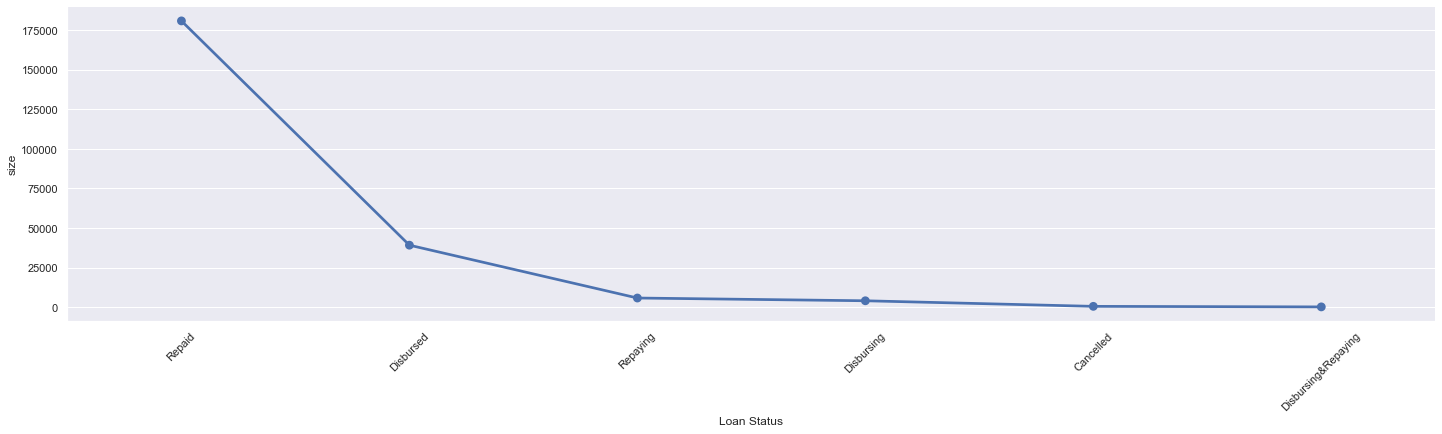

In [86]:
#Group by loan status then sort by count in decending order
loanStatusCount = IBRDLoans.groupby('Loan Status', as_index=False)['Loan Status'].size().reset_index().sort_values(
    by = 'size', ascending = False)

chart = sns.catplot(x='Loan Status', y='size', kind="point", data=loanStatusCount, aspect=4)
chart.set_xticklabels(rotation=45)

print('As per the plot below, most loans are %s (%d) whereas a small number of loans are %s (%d)' 
      % (loanStatusCount.query('size == size.max()').loc[loanStatusCount.query('size == size.max()').index[0], 'Loan Status'], loanStatusCount['size'].max(),
     loanStatusCount.query('size == size.min()').loc[loanStatusCount.query('size == size.min()').index[0], 'Loan Status'], loanStatusCount['size'].min()))

Showcasing lowest 10 countries in terms of Repaid Percentages (what percentage of the loan amount was repaid)

The plot below shows countries with lowest repayment percentages. Uzbekistan has a repayment percentage of (73.866149%), while Zimbabwe has the lowest repayment percentage (37.227823%)


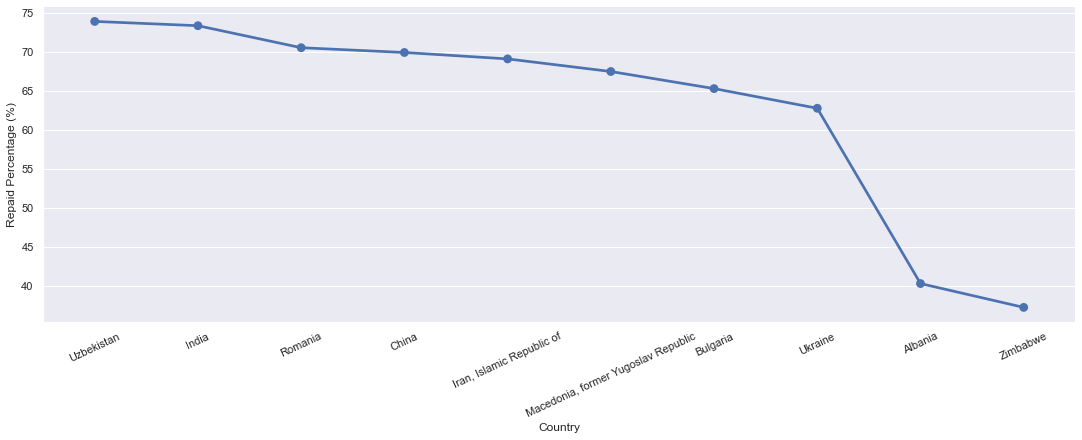

In [87]:
#Group dataframe by Country
CountryLoans = IBRDLoans.groupby('Country', as_index = False).sum()

#Calculate actual amount by subtracting Cancelled Amount from Original Principal Amount
actualLoanAmount = CountryLoans['Original Principal Amount'] - CountryLoans['Cancelled Amount']
#Create a new columns to hold the actual amount value
CountryLoans ['Actual Loan Amount'] = actualLoanAmount
#Repaid Percentage = (Actual Amount - Borrower's Obligation) / Actual Amount * 100
CountryLoans['Repaid Percentage (%)'] = (CountryLoans ['Actual Loan Amount'] - 
                                         CountryLoans["Borrower's Obligation"]) / CountryLoans ['Actual Loan Amount'] *100

#Sort dataframe by Repaid Percentage in Decending order
CountryLoans = (CountryLoans[['Country', 'Actual Loan Amount', "Borrower's Obligation", 
                              'Repaid Percentage (%)']].sort_values(by = 'Repaid Percentage (%)', 
                                                                    ascending = False))

#Find 10 countries with lowest Repaid Percentage and sort them in Decending order
lowest = CountryLoans.nsmallest(10,'Repaid Percentage (%)').sort_values(
                                        by = 'Repaid Percentage (%)',ascending = False)

chart = sns.catplot(x="Country", y="Repaid Percentage (%)", 
            data=lowest, kind='point', aspect = 3)
chart.set_xticklabels(rotation=25)

#Find country with lowest Repaid Percentage
minCountry = lowest[lowest['Repaid Percentage (%)'] == lowest['Repaid Percentage (%)']
                          .min()].loc[lowest[lowest['Repaid Percentage (%)'] == lowest['Repaid Percentage (%)'].min()].index[0], 'Country']

#Find the 10th lowest country 
maxCountry = lowest[lowest['Repaid Percentage (%)'] == lowest['Repaid Percentage (%)']
                          .max()].loc[lowest[lowest['Repaid Percentage (%)'] == lowest['Repaid Percentage (%)'].max()].index[0], 'Country']


print('The plot below shows countries with lowest repayment percentages. %s has a repayment percentage of (%f%%), while %s has the lowest repayment percentage (%f%%)' 
      % (maxCountry, lowest['Repaid Percentage (%)'].max(), minCountry, lowest['Repaid Percentage (%)'].min()))

Looking for a relationship between the loan amount and allowed repayment duration in days (starting from first to last repayment dates)

As per the plot and table below, it can be seen that the average number of days to repay the loan largly depends on the avergae amount of the loan.
Generally, the higher the loan amount, the longer repayment days are.


,Deciles,Repayment Duration (Days),Average Loans Held,Average Interest Rate
0,"(0.009000000000000001, 1285179.13]",4596.927431,5.170093e+05,1.893082
1,"(1285179.13, 3255892.76]",4724.342845,2.238562e+06,1.826906
2,"(3255892.76, 6447864.168]",4740.904194,4.742009e+06,1.604673
3,"(6447864.168, 10880613.718]",4697.775176,8.569150e+06,1.628173
4,"(10880613.718, 17525000.0]",4729.058298,1.383551e+07,1.796630
5,"(17525000.0, 27195000.0]",4758.537021,2.198056e+07,1.788638
6,"(27195000.0, 46736054.79]",4820.886262,3.584107e+07,1.552803
7,"(46736054.79, 74453654.22]",4866.606261,5.960594e+07,1.353580
8,"(74453654.22, 124745000.0]",4971.478085,9.627033e+07,1.418913
9,"(124745000.0, 600000000.0]",5032.720009,2.063960e+08,1.111867


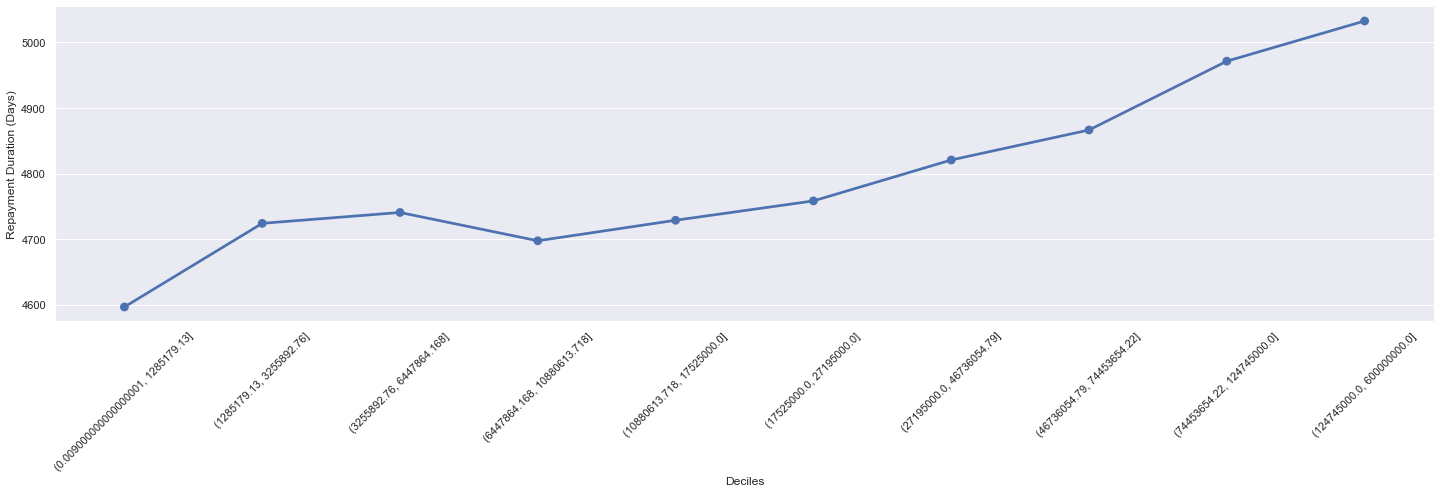

In [88]:
#Preparing the repayment dataframe to include the dates and loan amount
repayments = IBRDLoans.loc[IBRDLoans['First Repayment Date'] < IBRDLoans['Last Repayment Date']]
repayments = repayments.loc[repayments['Loans Held'] > 0]

#Calculating the duration
repayments['Repayment Duration (Days)'] = repayments['Last Repayment Date'] - repayments['First Repayment Date']
repayments['Repayment Duration (Days)'] = repayments['Repayment Duration (Days)'].dt.days
repayments = repayments[['Repayment Duration (Days)', 'Loans Held', 'Interest Rate']]

#Categorizing the loan amounts into 10 categories (deciles) and then calculating the mean for each category
repayments['Deciles'] = pd.qcut(repayments['Loans Held'], 10)
repayments = repayments.groupby('Deciles').mean().reset_index()
repayments.rename(columns={"Loans Held": "Average Loans Held", 
                           "Interest Rate": "Average Interest Rate"}, inplace = True)

chart = sns.catplot(x="Deciles", y="Repayment Duration (Days)",  
            data=repayments, kind='point', aspect = 4);
chart.set_xticklabels(rotation=45)

print('As per the plot and table below, it can be seen that the average number of days to repay the loan largly depends on the avergae amount of the loan.\n'
      'Generally, the higher the loan amount, the longer repayment days are.')

repayments

Showcasing the yearly Interest Rate distributions in MENA based on the Board Approval Date

The figure below shows the yearly mean interest rate has dropped to 2% in 2005 compared to approximately 10% in 1982


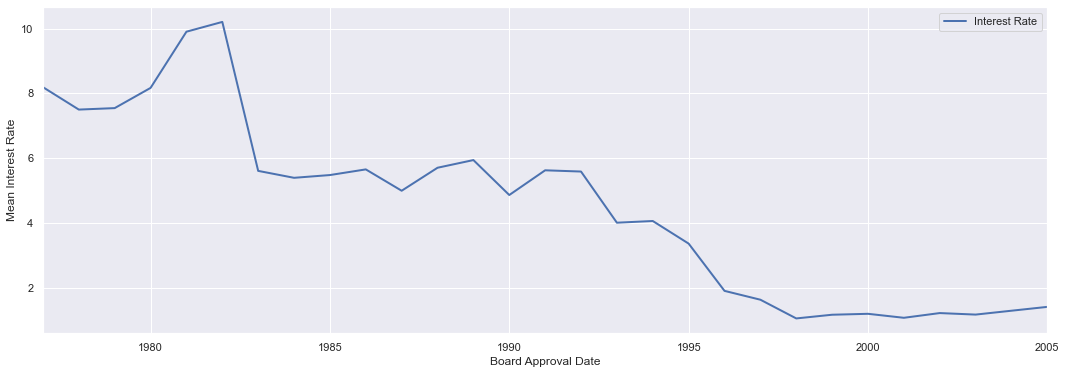

In [89]:
#Preparing the dataframe
IR = IBRDLoans.query('Region == "Middle east and north africa"')
IR = IR[['Interest Rate', 'Board Approval Date']]
IR.set_index('Board Approval Date', inplace = True)

#Resampling it on yearly basis 
yearly_IR = IR.resample('Y').mean()

fig, ax = plt.subplots(figsize=(18,6))
yearly_IR.plot(style = '-', ax=ax, lw=2)
plt.ylabel('Mean Interest Rate');

print('The figure below shows the yearly mean interest rate has dropped to 2% in 2005 compared to approximately 10% in 1982')

Overview of interest rate per region and loan type

As per the plot below, South asia has the highest interest rate(8.238924 in average) whereas Middle east and north africa has the lowest interest rate(1.034148 in average)


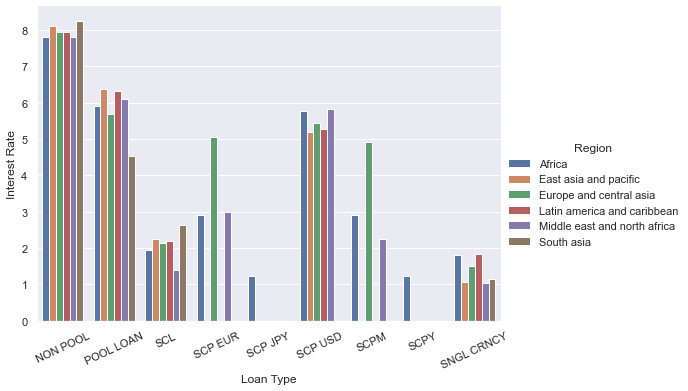

In [90]:
#Group dataset by region then loan type
groupedData = (IBRDLoans.groupby(['Region', 'Loan Type'], as_index=False)).mean()

chart = sns.catplot(x="Loan Type", y="Interest Rate", hue = 'Region',
            data=groupedData, kind='bar', aspect=11.7/8.27)
chart.set_xticklabels(rotation=25)

#Find Region with highest Interest Rate
maxRegion = groupedData[groupedData['Interest Rate'] == groupedData['Interest Rate'].max()].loc[
    groupedData[groupedData['Interest Rate'] == groupedData['Interest Rate'].max()].index[0], 'Region']

#Find Region with lowest Interest Rate
minRegion = groupedData[groupedData['Interest Rate'] == groupedData['Interest Rate'].min()].loc[
    groupedData[groupedData['Interest Rate'] == groupedData['Interest Rate'].min()].index[0], 'Region']

print('As per the plot below, %s has the highest interest rate(%f in average) whereas %s has the lowest interest rate(%f in average)' 
      % (maxRegion, groupedData['Interest Rate'].max(), minRegion, groupedData['Interest Rate'].min()))

# Linear Regression

A Linear Regression model to predict Interest Rate based on Original Principal Value and Loan Type.

In [91]:
#Retrieving the required data and cleaning it
loans_held = IBRDLoans[(IBRDLoans["Original Principal Amount"].isna() == False)]
loans_held["Original Principal Amount"] = (loans_held["Original Principal Amount"]).astype(float)

loans_held = loans_held[(loans_held["Interest Rate"].isna() == False)]
loans_held["Interest Rate"] = (loans_held["Interest Rate"]).astype(float)

loans_held = (loans_held[['Region', 'Loan Type', 'Interest Rate', 
                          'Original Principal Amount']].copy())


Label Encoding for some categorical attributes (Region and Loan Type)

In [92]:
le = preprocessing.LabelEncoder()
#Region
le.fit(loans_held['Region'])
loans_held['Region_Encoded'] = le.fit_transform(loans_held['Region'])
#Loan_Type
le.fit(loans_held['Loan Type'])
loans_held['Loan_Type_Encoded'] = le.fit_transform(loans_held['Loan Type'])

K-best is a feature selecting technique that enables us to pick top 2 features affecting Interest Rate (target) out of 3 possible features ('Region', 'Loan_Type' and 'Original Principal Amount')

In [93]:
X_full = loans_held[['Region_Encoded', 'Loan_Type_Encoded', 
                          'Original Principal Amount']]
y = loans_held['Interest Rate']
selector = SelectKBest(f_regression, k=2)
selector.fit(X_full, y)

print('K-best result: ', selector.get_support())
print('Loan Type and OPA will be used')

K-best result:  [False  True  True]
Loan Type and OPA will be used


In [94]:
numerical_attr = ['Original Principal Amount']
#Loan Type
print('Number of Loan Types: ', len(loans_held['Loan Type'].unique()))

Number of Loan Types:  9


There are 9 different loan types. Converting them all to dummies will create too many variables.
Loan Types with freq < 5 will be grouped into 1 group
0% < freq <= 5%: low_freq

In [95]:
freq = (loans_held['Loan Type'].value_counts() / len(loans_held['Loan Type']))*100
print('Frequency of each loan type:\n', freq)
#Grouping
loans_held['Loan_Type_Group'] = ["low_freq" if freq[loans_held['Loan Type'][i]] < 5 
                                      else loans_held['Loan Type'][i]
                                      for i in range(len(loans_held['Loan Type']))]

Frequency of each loan type:
 POOL LOAN     59.878223
SNGL CRNCY    28.492629
SCP USD        3.851211
NON POOL       3.839060
SCL            3.260120
SCP EUR        0.578506
SCPM           0.065966
SCP JPY        0.030813
SCPY           0.003472
Name: Loan Type, dtype: float64


Create Dummies

In [101]:
#Loan Type
loan_type_dummies = pd.get_dummies(loans_held['Loan_Type_Group'], drop_first=True)

#Concatinate them to the dataset
loans_held_dummy = pd.concat([loans_held, loan_type_dummies], axis = 1)
loans_held_dummy.head()

#'POOL LOAN' is not included to avoid the dummy variable trap
binary_attr = ['SNGL CRNCY', 'low_freq']

Define Dependent and Independent variables, and create model instance

In [102]:
#Independant variables
X_linear = loans_held_dummy[numerical_attr + binary_attr]
#Dependent variable
y = loans_held.loc[:, 'Interest Rate'].values
#Create model instance
model = LinearRegression()

Polynomial Features is a way to increase the complexity of the linear model to avoid under-fitting the model and increase prediction accuracy

In [103]:
poly = PolynomialFeatures(degree=2)
#fit_transform for all independant variables
X_poly = []
X_poly = [poly.fit_transform(X_linear.iloc[:, i].values.reshape(-1,1)) 
          for i in range(0, X_linear.shape[1])]
#Convert to DataFrame
X_poly_df = [pd.DataFrame(X_poly[i]) for i in range(0, len(X_poly))]
X_poly_df = pd.concat(X_poly_df, axis=1)

Split the dataset: 30% test, 70% train and fit the model

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    X_poly_df, y, test_size=0.3)

Scaling the independant features and fitting the model on the scaled training data

Standard scaling is a way to normalize the features used in the model by transforming each feature (each column) to have mean = 0 and sd = 1

In [105]:
#Create scaler instance
scaler_x = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

#Fit the model
model.fit(X_train, y_train)

LinearRegression()

Predict and show performance

R-squared score: 50.0023%


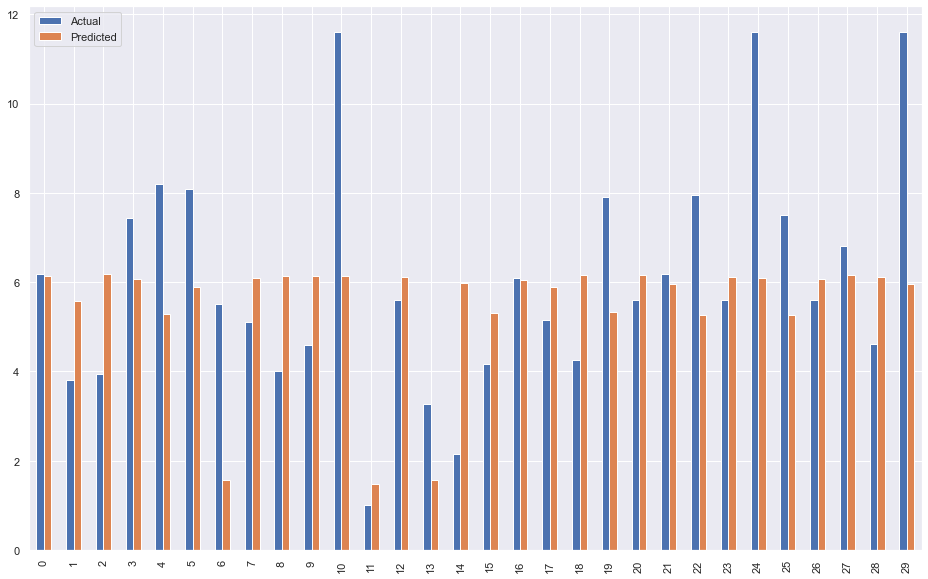

In [106]:
#Predict y
y_pred = model.predict(X_test)
#R-squared Score
print("R-squared score: {:.4f}%".format(model.score(X_test, y_test)*100))

actual_predicted = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
actual_predicted.head(30).plot(kind='bar',figsize=(16,10))
plt.show()

# Gaussian Naïve Bayes

Naive Bayes is a machine learning classifier that is based on Bayes theorem:

P(A|B) = P(B|A) * P(A) / P(B)

It is a way to find the probability of an event happening (A) given that another event has occured (B).


In this project, we are classifying whether a loan is repaid or not given the Country and Loan Type

In [107]:
nb_df = IBRDLoans.copy()

#Converting tagret to binary values (1 for repaid, 0 otherwise)
nb_df['Loan Status'] = [1 if (nb_df.loc[i, 'Loan Status'] == 'Repaid') else 0 for i in range(len(nb_df))]

feature_names = ['Country', 'Loan Type']

nb_df = nb_df[feature_names + ['Loan Status']]

Label Encoding

In [108]:
#Encoding feature names
le = {}
for col in nb_df.columns:
    le[col] = preprocessing.LabelEncoder()
    le[col].fit(nb_df[col].unique())
    nb_df[col] = le[col].transform(nb_df[col])

Define Dependent and Independent variables, and create model instance

In [109]:
gnb = GaussianNB()
X = nb_df[feature_names]
y = nb_df['Loan Status']

Split the dataset: 30% test, 70% train and fit the model

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

gnb.fit(X_train.values, y_train)

GaussianNB()

Predict and show performance

Number of mislabeled points out of a total 230421 points : 10395, performance 95.49%


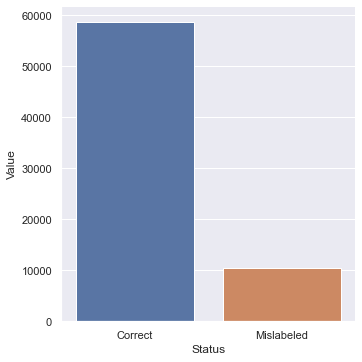

In [111]:
y_pred = gnb.predict(X_test)

#Calculate performance and accuracy
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          nb_df.shape[0],
          (y_test != y_pred).sum(),
          100*(1-(y_test != y_pred).sum()/nb_df.shape[0])
))

correct_mislabeled = pd.DataFrame({'Status': ['Correct', 'Mislabeled'], 
                                  'Value': [(y_test == y_pred).sum(), (y_test != y_pred).sum()]})
sns.catplot(x="Status", y="Value",  
             data=correct_mislabeled, kind='bar')